In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas
from astropy import units as u
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
from read_mist_models import ISOCMD
import astropy.coordinates as coord
from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.data import download_file
import scipy
import scipy as stats
from astroquery.gaia import Gaia
from astroquery.sdss import SDSS
import glob


#copy and paste code cite vespa anyways

In [1]:
path =  r'C:\Users\astro\SSG_Spectra\Metallicities\\' #get dat here
file = path + 'ssg_table1.txt'
gaia_ids = np.genfromtxt(file, usecols= 0, dtype = str)
gaia_ids2 = list(np.genfromtxt(file, usecols= 0, dtype = np.int64))
gaia_ids = str(list(gaia_ids)).strip('[]')




In [2]:
#Do Not Mess with Query

query_text = f'''SELECT TOP 10000 *
FROM gaiadr3.gaia_source 
WHERE gaiadr3.gaia_source.source_id IN ({gaia_ids})'''
job = Gaia.launch_job(query_text) 
gaia_data = job.get_results()


In [3]:
print(job)

<Table length=1895>
              name               dtype       unit                                                                  description                                                              n_bad
------------------------------- ------- ------------- ------------------------------------------------------------------------------------------------------------------------------------- -----
                    solution_id   int64                                                                                                                                 Solution Identifier     0
                    DESIGNATION  object                                                                                         Unique source designation (unique across all Data Releases)     0
                      SOURCE_ID   int64                                                                                  Unique source identifier (unique within a particular Data Release)     0
          

In [4]:
gaia_data['SOURCE_ID', 'ra','dec', 'rv_template_fe_h', 'mh_gspphot'] #Create tables 

SOURCE_ID,ra,dec,rv_template_fe_h,mh_gspphot
,deg,deg,dex,dex
int64,float64,float64,float32,float32
18910470421959808,40.65095558618673,7.290585245493459,-0.25,--
34148700855166720,43.83780066505116,15.656337721802666,0.0,--
54254958891842816,51.01410355127157,15.47253974991323,-0.25,-0.4777
65719566637012992,58.44664614163716,23.83542417189985,-0.5,-1.4311
71640436752289408,56.90332442047046,28.10701870991814,--,-0.3814
81709523719057536,40.68759334849107,16.305496512913244,--,-0.5055
83339790224838784,41.88059999692063,17.268300455125537,-0.5,-0.1972
83540210579216128,42.762736423881336,18.213725388984724,--,-0.3595


In [5]:
c = SkyCoord(ra=gaia_data['ra'], dec=gaia_data['dec'], frame='icrs')
ra = c.ra.wrap_at(180 * u.deg).radian
dec = c.dec.radian
metallicity = np.array(gaia_data['mh_gspphot'], dtype = float)

dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
m_G = np.array(gaia_data['phot_g_mean_mag'], dtype = float)
uncorr_bp_rp = np.array(gaia_data['bp_rp'], dtype = float)
distance = np.array(dist, dtype = float)

In [6]:
av_tot = np.genfromtxt(file, usecols=16, dtype=float)
av = np.array([av_tot[gaia_ids2.index(item)] for item in gaia_data['SOURCE_ID']], 
              dtype = float)



#Reddening
ag = av*0.789
Ebp_rp = ag/1.890 #ag/e(bp=rp) = 1.890
bp_rp = uncorr_bp_rp + Ebp_rp
M_G = -5*np.log10(distance) + m_G - ag + 5 #m-M = 5log(d) - 5 + Av

C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:3710: RuntimeWarning: invalid value encountered in divide
  return sin(y)/y


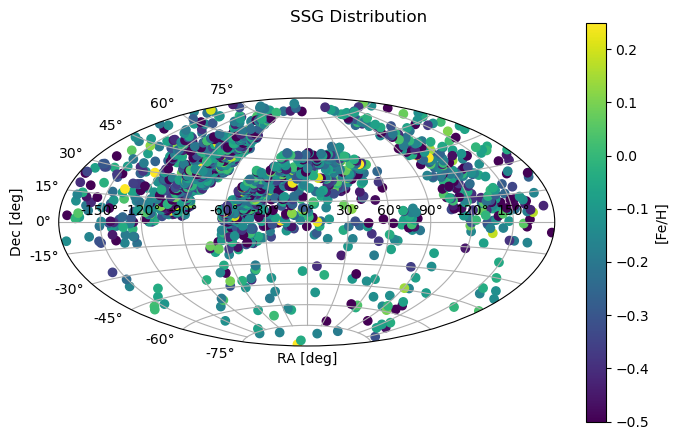

In [7]:
fig, ax = plt.subplots(figsize=(8,4.2), 
                       subplot_kw=dict(projection="aitoff"))
fig.suptitle('SSG Distribution')
cs = ax.scatter(ra, dec, c=metallicity, vmin=-0.50, vmax=0.25)


ax.grid()

cb = fig.colorbar(cs)

cb.set_label('[Fe/H]')
#mpl.cm.set_clim.cb(vmax = 0.25) 
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
fig.subplots_adjust(top=0.95,bottom=0.0)


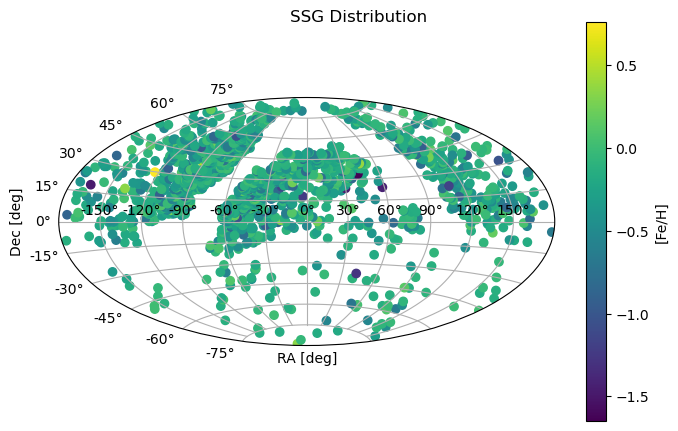

In [8]:
fig, ax = plt.subplots(figsize=(8,4.2), 
                       subplot_kw=dict(projection="aitoff"))
fig.suptitle('SSG Distribution')
cs = ax.scatter(ra, dec, c=metallicity)


ax.grid()

cb = fig.colorbar(cs)

cb.set_label('[Fe/H]')
#mpl.cm.set_clim.cb(vmax = 0.25) 
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
fig.subplots_adjust(top=0.95,bottom=0.0)

Text(0, 0.5, 'Number of Stars')

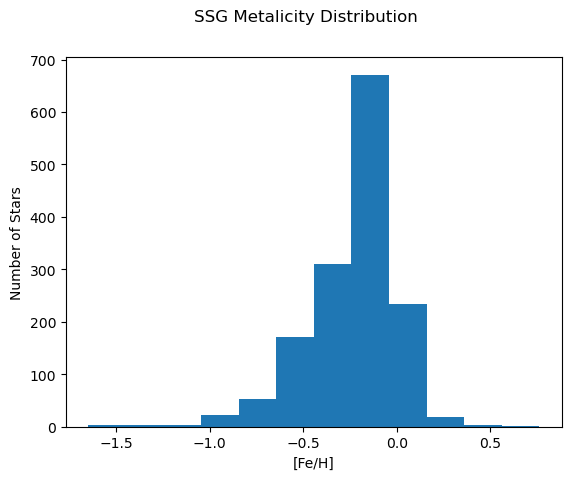

In [9]:
#fill in the missing code to create a histogram of Z, the height above/below the midplane.
#matplotlib.pyplot.hist documentation is here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(metallicity, 12)
plt.suptitle('SSG Metalicity Distribution')
plt.xlabel("[Fe/H]")
plt.ylabel("Number of Stars")

In [10]:
valid_feh = metallicity >= -100

print(np.mean(metallicity[valid_feh]))
print(np.std(metallicity[valid_feh]))
print(max(metallicity[valid_feh]))

-0.23361505999646165
0.23960465016093974
0.7620000243186951


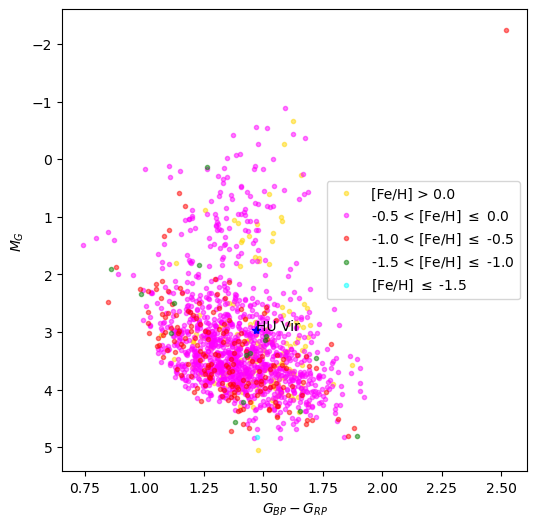

In [11]:
#Compare isocrone for all
#Once you have calculated M_G and BP_RP above,
#this code will generage a CMD of our stellar sample,
#highlighting a subsample of the highest and lowest mass stars

#highlight HU Vir, FN Com
HUVir = gaia_data['SOURCE_ID'] == 3582095053777917952 #HU Vir
FNCom = gaia_data['SOURCE_ID'] == 3947234928261838720 #FN Com

#Defining metallicty samples
fe_h1 = (metallicity > 0.0)
fe_h2 = (metallicity <= 0.0) & (metallicity > -0.5)
fe_h3 = (metallicity <= -0.5) & (metallicity > -1.0)
fe_h4 = (metallicity <= -1.0) & (metallicity > -1.5)
fe_h5 = (metallicity <= -1.5) & (metallicity >= -100)
#plotting colors for each sample

#plot a CMD with low and high mass samples highlighted
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(bp_rp[fe_h1], M_G[fe_h1], marker='.', linestyle='none', 
        alpha=0.5, color = 'gold', label = '[Fe/H] > 0.0')
ax.plot(bp_rp[fe_h2], M_G[fe_h2], marker='.', linestyle='none', 
        alpha=0.5, color = 'magenta', label = '-0.5 < [Fe/H] $\leq$ 0.0')
ax.plot(bp_rp[fe_h3], M_G[fe_h3], marker='.', linestyle='none', 
        alpha=0.5, color = 'red', label = '-1.0 < [Fe/H] $\leq$ -0.5')
ax.plot(bp_rp[fe_h4], M_G[fe_h4], marker='.', linestyle='none', 
        alpha=0.5, color = 'green', label = '-1.5 < [Fe/H] $\leq$ -1.0')
ax.plot(bp_rp[fe_h5], M_G[fe_h5], marker='.', linestyle='none', 
        alpha=0.5, color = 'cyan', label = '[Fe/H] $\leq$ -1.5')

#Highlight the targest stars
ax.plot(bp_rp[HUVir], M_G[HUVir], marker='*', linestyle='none', 
        alpha=1, color = 'blue')
ax.text(bp_rp[HUVir], M_G[HUVir], 'HU Vir')

#ax.plot(bp_rp[FNCom], M_G[FNCom], marker='*', linestyle='none', 
        #alpha=1, color = 'blue')

#ax.text(bp_rp[FNCom], M_G[FNCom], 'FN Com')
'''
for mask, color in zip([fe_h1, fe_h2, fe_h3, fe_h4, fe_h5],
                       ['gold', 'blue','red', 'green', 'cyan']):
    ax.plot(bp_rp[mask], M_G[mask],
            marker='.', linestyle='none',
            alpha=0.5, color=color)
'''


#ax.set_xlim(0, 3)
#ax.set_ylim(11, 1)
ax.invert_yaxis()
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')
ax.legend()

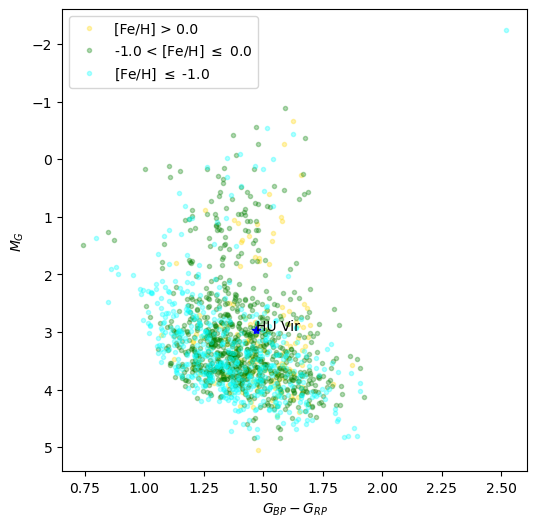

In [12]:
#Compare isocrone for all
#Once you have calculated M_G and BP_RP above,
#this code will generage a CMD of our stellar sample,
#highlighting a subsample of the highest and lowest mass stars

#highlight HU Vir, FN Com
HUVir = gaia_data['SOURCE_ID'] == 3582095053777917952 #HU Vir
FNCom = gaia_data['SOURCE_ID'] == 3947234928261838720 #FN Com

#Defining metallicty samples
fe_h1b = (metallicity > 0.0)
fe_h2b = (metallicity <= 0.0) & (metallicity > -0.25)
fe_h3b = (metallicity <= -0.25) & (metallicity >= -100)
#plotting colors for each sample

#plot a CMD with low and high mass samples highlighted
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(bp_rp[fe_h1b], M_G[fe_h1b], marker='.', linestyle='none', 
        alpha=0.3, color = 'gold', label = '[Fe/H] > 0.0')
ax.plot(bp_rp[fe_h2b], M_G[fe_h2b], marker='.', linestyle='none', 
        alpha=0.3, color = 'green', label = '-1.0 < [Fe/H] $\leq$ 0.0')
ax.plot(bp_rp[fe_h3b], M_G[fe_h3b], marker='.', linestyle='none', 
        alpha=0.3, color = 'cyan', label = '[Fe/H] $\leq$ -1.0')
#Highlight the targest stars
ax.plot(bp_rp[HUVir], M_G[HUVir], marker='*', linestyle='none', 
        alpha=1, color = 'blue')

ax.text(bp_rp[HUVir], M_G[HUVir], 'HU Vir')
'''
ax.plot(bp_rp[FNCom], M_G[FNCom], marker='*', linestyle='none', 
        alpha=1, color = 'blue')
ax.text(bp_rp[FNCom], M_G[FNCom], 'FN Com')
'''


#ax.set_xlim(0, 3)
#ax.set_ylim(11, 1)
ax.invert_yaxis()
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')
ax.legend()
#Paper here finds gaia metallicty is accurate for the most part

In [13]:
print(av[HUVir])
print(Ebp_rp[HUVir])

[0.11]
[0.04592063]


In [14]:
iso_file00 = r"C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bd9dbb9411.iso.cmd"
iso_file_low025 = r"C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bdd54012f6.iso.cmd"
iso_file05 = r"C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bdbe235892.iso.cmd"
iso_file_HUVir = r"C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_67a40a1eec2f1.iso.cmd"
iso_00 = ISOCMD(iso_file00)
iso_low025 = ISOCMD(iso_file_low025)
iso_05 = ISOCMD(iso_file05)
iso_HUVir = ISOCMD(iso_file_HUVir)

Reading in: C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bd9dbb9411.iso.cmd
Reading in: C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bdd54012f6.iso.cmd
Reading in: C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bdbe235892.iso.cmd
Reading in: C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_67a40a1eec2f1.iso.cmd


In [15]:
#age_ind = isocmd.age_index(9.6) #returns the index for the desired age
G_00 = iso_00.isocmds[0]['Gaia_G_EDR3']
BP_RP00 = iso_00.isocmds[0]['Gaia_BP_EDR3'] - iso_00.isocmds[0]['Gaia_RP_EDR3']

G_05 = iso_05.isocmds[0]['Gaia_G_EDR3']
BP_RP05 = iso_05.isocmds[0]['Gaia_BP_EDR3'] - iso_05.isocmds[0]['Gaia_RP_EDR3']

G_low025 = iso_low025.isocmds[0]['Gaia_G_EDR3']
BP_RP_low025 = iso_low025.isocmds[0]['Gaia_BP_EDR3'] - iso_low025.isocmds[0]['Gaia_RP_EDR3']

In [16]:
#BC tool https://www.cosmos.esa.int/web/gaia/dr3-bolometric-correction-tool

In [17]:
print(iso_00.hdr_list)
print(iso_00.isocmds[0]['EEP'])

['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 'Gaia_RP_DR2Rev', 'Gaia_G_MAW', 'Gaia_BP_MAWb', 'Gaia_BP_MAWf', 'Gaia_RP_MAW', 'TESS', 'Gaia_G_EDR3', 'Gaia_BP_EDR3', 'Gaia_RP_EDR3', 'phase']
[ 269  270  271 ... 1708 1709 1710]


In [18]:
print(BP_RP05)

#log10(age) =a
# 

[ 4.750306  4.750807  4.751385 ... -0.348702 -0.335184 -0.321634]


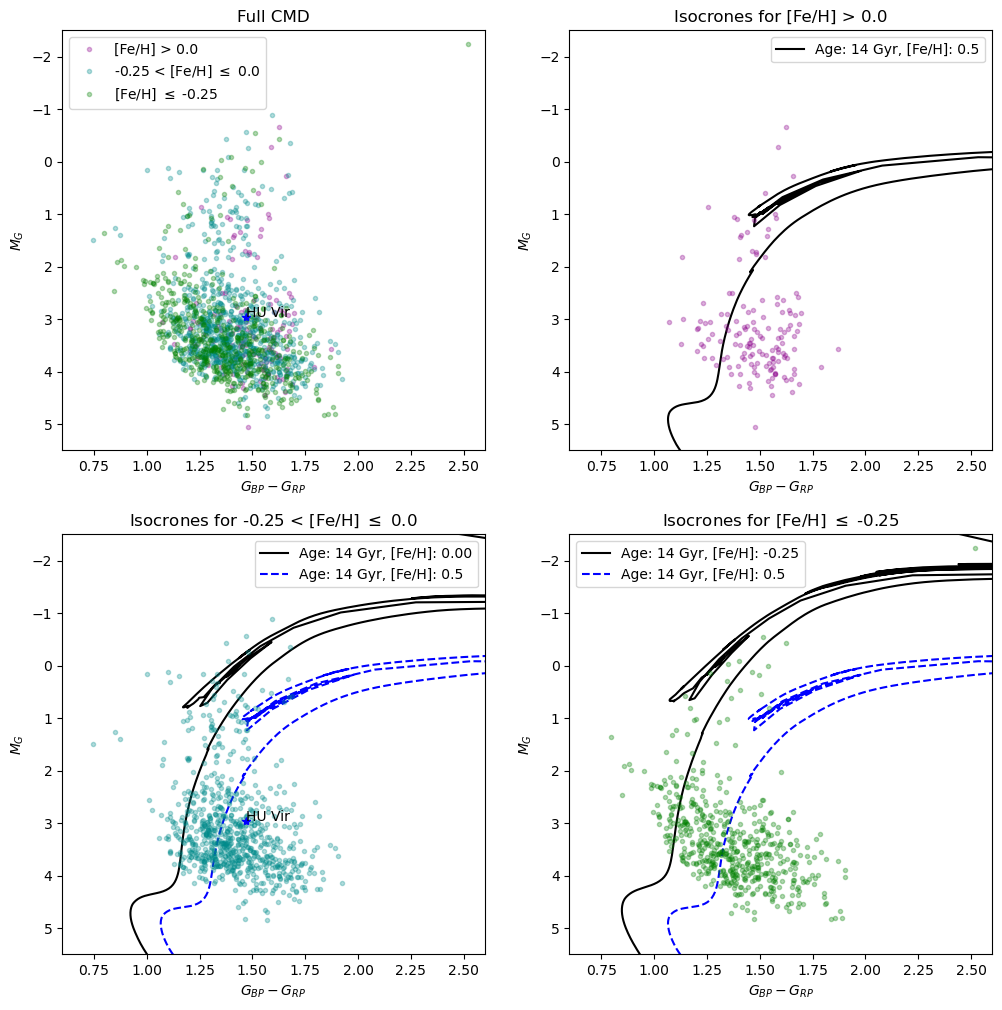

In [19]:
#Subsample ([Fe/H] >= 0.0)
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
#full Sample
ax[0,0].set_title('Full CMD')
ax[0,0].plot(bp_rp[fe_h1b], M_G[fe_h1b], marker='.', linestyle='none', 
        alpha=0.3, color = 'darkmagenta', label = '[Fe/H] > 0.0')
ax[0,0].plot(bp_rp[fe_h2b], M_G[fe_h2b], marker='.', linestyle='none', 
        alpha=0.3, color = 'darkcyan', label = '-0.25 < [Fe/H] $\leq$ 0.0')
ax[0,0].plot(bp_rp[fe_h3b], M_G[fe_h3b], marker='.', linestyle='none', 
        alpha=0.3, color = 'green', label = '[Fe/H] $\leq$ -0.25')
#Highlight the targest stars
ax[0,0].plot(bp_rp[HUVir], M_G[HUVir], marker='*', linestyle='none', 
        alpha=1, color = 'blue')
#ax[0,0].plot(bp_rp[FNCom], M_G[FNCom], marker='*', linestyle='none', alpha=1, color = 'blue')
#ax[0,0].text(bp_rp[FNCom], M_G[FNCom], 'FN Com')
ax[0,0].text(bp_rp[HUVir], M_G[HUVir], 'HU Vir')

ax[0,0].set_xlim(0.60, 2.60)
ax[0,0].set_ylim(-2.5,5.5)
ax[0,0].invert_yaxis()
ax[0,0].set_xlabel('$G_{BP}-G_{RP}$')
ax[0,0].set_ylabel('$M_G$')

ax[0,0].legend()

#Subsample 1
ax[0,1].plot(BP_RP05, G_05, color = 'black', label='Age: 14 Gyr, [Fe/H]: 0.5')
ax[0,1].set_title(r'Isocrones for [Fe/H] > 0.0')
ax[0,1].plot(bp_rp[fe_h1b], M_G[fe_h1b],
        marker='.', linestyle='none', alpha=0.3, color = 'darkmagenta')
#ax[0,1].plot(iso['logTeff'], iso['logL'], label=f'Age: 14 Gyr, [Fe/H]: 0.50')
ax[0,1].set_xlim(0.60, 2.60)
ax[0,1].set_ylim(-2.5,5.5)
ax[0,1].invert_yaxis()
ax[0,1].set_xlabel('$G_{BP}-G_{RP}$')
ax[0,1].set_ylabel('$M_G$')
ax[0,1].legend()
#Subsample 2
ax[1,0].set_title(r'Isocrones for -0.25 < [Fe/H] $\leq$ 0.0')
ax[1,0].plot(BP_RP00, G_00, color = 'black', label='Age: 14 Gyr, [Fe/H]: 0.00')
#ax[1,0].plot(BP_RP_low025, G_low025, color = 'red', linestyle = '-.', label='Age: 14 Gyr, [Fe/H]: -0.25')
ax[1,0].plot(BP_RP05, G_05, color = 'blue', linestyle = '--', label='Age: 14 Gyr, [Fe/H]: 0.5')
ax[1,0].plot(bp_rp[fe_h2b], M_G[fe_h2b], 
             marker='.', linestyle='none', alpha=0.3, color = 'darkcyan')
ax[1,0].set_xlim(0.60, 2.60)
ax[1,0].set_ylim(-2.5,5.5)
ax[1,0].invert_yaxis()
ax[1,0].set_xlabel('$G_{BP}-G_{RP}$')
ax[1,0].set_ylabel('$M_G$')

ax[1,0].plot(bp_rp[HUVir], M_G[HUVir], marker='*', linestyle='none', 
        alpha=1, color = 'blue')
ax[1,0].text(bp_rp[HUVir], M_G[HUVir], 'HU Vir')
ax[1,0].legend()
#Subsample 3
ax[1,1].set_title(r'Isocrones for [Fe/H] $\leq$ -0.25')
ax[1,1].plot(BP_RP_low025, G_low025, color = 'black', label='Age: 14 Gyr, [Fe/H]: -0.25')
ax[1,1].plot(BP_RP05, G_05, color = 'blue', linestyle = '--', label='Age: 14 Gyr, [Fe/H]: 0.5')
ax[1,1].plot(bp_rp[fe_h3b], M_G[fe_h3b],
             marker='.', linestyle='none', alpha=0.3, color = 'green')

ax[1,1].set_xlim(0.60, 2.60)
ax[1,1].set_ylim(-2.5,5.5)
ax[1,1].invert_yaxis()
ax[1,1].set_xlabel('$G_{BP}-G_{RP}$')
ax[1,1].set_ylabel('$M_G$')
ax[1,1].legend()


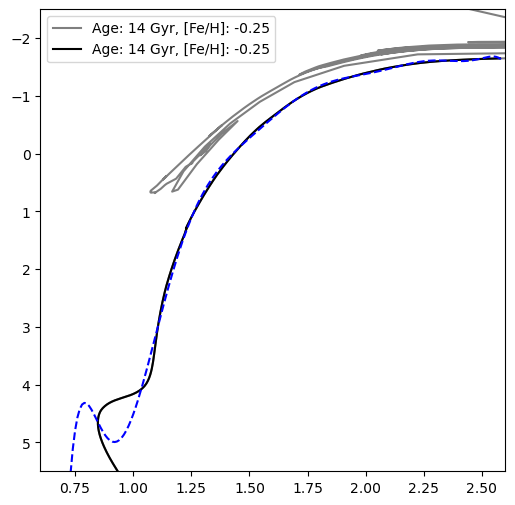

In [20]:

fitlim_05 = ((BP_RP05 >= 0.65) & (BP_RP05 <= 2.60)
            & (G_05 >= -2.5) & (G_05 <= 5.5))
fitlim_00 = ((BP_RP00 >= 0.65) & (BP_RP00 <= 2.60)
            & (G_00 >= -2.5) & (G_00 <= 5.5))
fitlim_low025 = ((BP_RP_low025 >= 0.65) & (BP_RP_low025 <= 2.60)
            & (G_low025 >= -2.5) & (G_low025 <= 5.5))

 #rcond==None, full==False, w==None, cov==False)4
MG_test = np.arange(0.65, 2.60, 0.01)

#Polyfiting
g_poly05 = np.polyfit(BP_RP05[fitlim_05][0:143], G_05[fitlim_05][0:143], 10)
p05 = np.poly1d(g_poly05)

g_poly00 = np.polyfit(BP_RP00[fitlim_00][0:177], G_00[fitlim_00][0:177], 10)
p00 = np.poly1d(g_poly00)

g_polylow025 = np.polyfit(BP_RP_low025[fitlim_low025][0:191], G_low025[fitlim_low025][0:191], 10)
p_low025 = np.poly1d(g_polylow025)

#Print the fits
fig, ax = plt.subplots(1, figsize=(6,6))
ax.plot(BP_RP_low025, G_low025, color = 'black', alpha = 0.5, label='Age: 14 Gyr, [Fe/H]: -0.25')
ax.plot(BP_RP_low025[fitlim_low025][0:191], G_low025[fitlim_low025][0:191], 
        color = 'black', label='Age: 14 Gyr, [Fe/H]: -0.25')
'''
ax.plot(BP_RP05, G_05, color = 'black', alpha = 0.5, label='Age: 14 Gyr, [Fe/H]: 0.5')
ax.plot(BP_RP05[fitlim_05][0:143], G_05[fitlim_05][0:143], color = 'black')
ax.plot(BP_RP00, G_00, color = 'black', alpha = 0.5, label='Age: 14 Gyr, [Fe/H]: 0.0')
ax.plot(BP_RP00[fitlim_00][0:177], G_00[fitlim_00][0:177], color = 'black')
'''
ax.plot(MG_test, p_low025(MG_test), color = 'blue', ls = '--')

ax.set_xlim(0.60, 2.60)
ax.set_ylim(-2.5,5.5)
ax.invert_yaxis()
ax.legend()

#ax[0,1].set_title(r'Isocrones for [Fe/H] $\geq$ 0.0')

In [21]:
ssg_05 = (M_G > p05(bp_rp))
ssg_00 = (M_G > p00(bp_rp))
ssg_low025 = (M_G > p_low025(bp_rp))

#ssgs = ((ssg_05 == True) | (ssg_00 == True) | (ssg_low025 == True))
#print(ssgs)

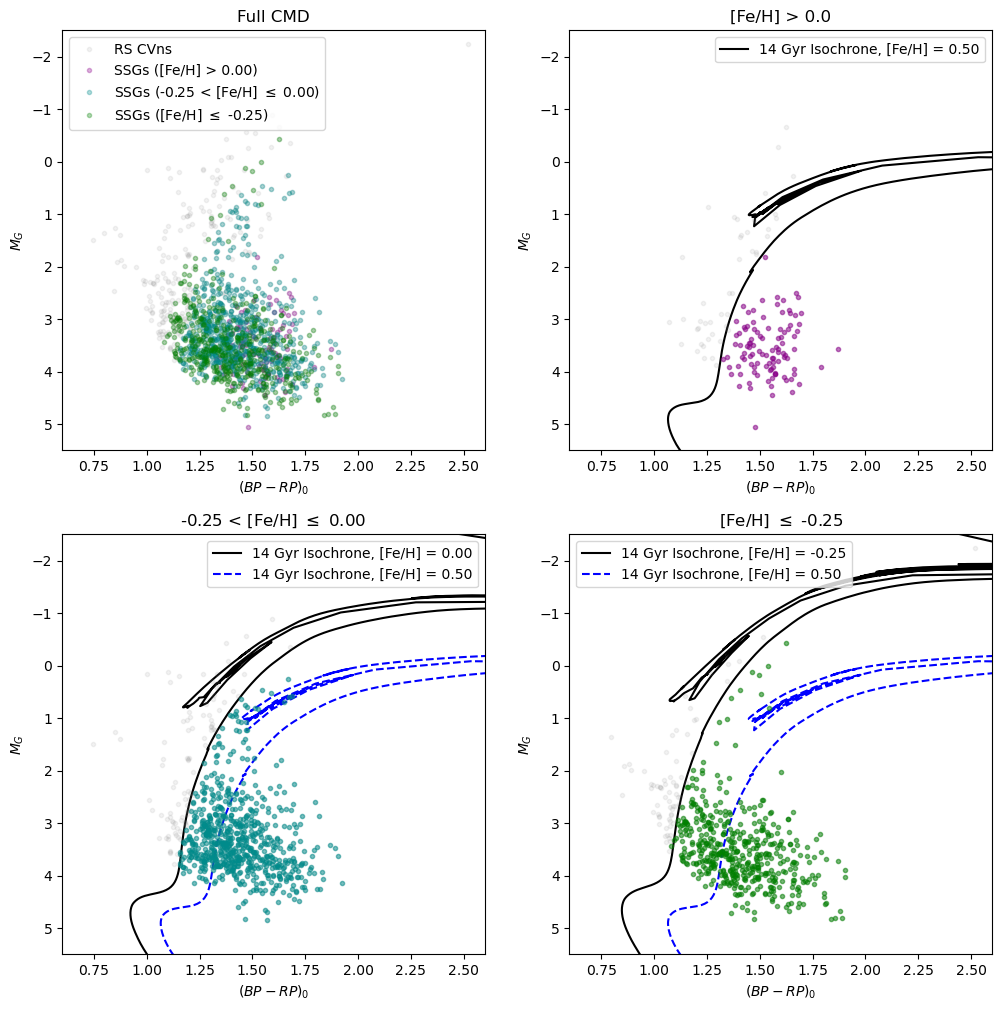

In [22]:

#Subsample ([Fe/H] >= 0.0)
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
#full Sample
ax[0,0].set_title('Full CMD')
#ax[0,0].plot(BP_RP05, G_05, color = 'black', marker = '+', label='Age: 14 Gyr, [Fe/H]: 0.5', linestyle= 'none')
ax[0,0].plot(bp_rp[valid_feh], M_G[valid_feh],
        marker='.', linestyle='none', alpha=0.1,color = 'gray', label = 'RS CVns')

ax[0,0].plot(bp_rp[fe_h1b & ssg_05], M_G[fe_h1b & ssg_05], marker='.', linestyle='none', 
        alpha=0.3, color = 'darkmagenta', label = 'SSGs ([Fe/H] > 0.00)')
ax[0,0].plot(bp_rp[fe_h2b & ssg_00], M_G[fe_h2b & ssg_00], marker='.', linestyle='none', 
        alpha=0.3, color = 'darkcyan', label = 'SSGs (-0.25 < [Fe/H] $\leq$ 0.00)')
ax[0,0].plot(bp_rp[fe_h3b & ssg_low025], M_G[fe_h3b & ssg_low025], marker='.', linestyle='none', 
        alpha=0.3, color = 'green', label = 'SSGs ([Fe/H] $\leq$ -0.25)')

#Highlight the targest stars
#ax[0,0].plot(bp_rp[HUVir], M_G[HUVir], marker='*', linestyle='none', alpha=1, color = 'blue')
#ax[0,0].text(bp_rp[HUVir], M_G[HUVir], 'HU Vir')

ax[0,0].set_xlim(0.60, 2.60)
ax[0,0].set_ylim(-2.5,5.5)
ax[0,0].invert_yaxis()
ax[0,0].set_xlabel('$(BP-RP)_0$')
ax[0,0].set_ylabel('$M_G$')

ax[0,0].legend()

#Subsample 1
ax[0,1].plot(BP_RP05, G_05, color = 'black', label='14 Gyr Isochrone, [Fe/H] = 0.50')
ax[0,1].set_title(r'[Fe/H] > 0.0')
#ax[0,1].plot(MG_test, p05(MG_test), color = 'b', ls = '--')
ax[0,1].plot(bp_rp[fe_h1b], M_G[fe_h1b],
        marker='.', linestyle='none', alpha=0.1,color = 'gray')#, color = 'darkmagenta')
ax[0,1].plot(bp_rp[fe_h1b & ssg_05], M_G[fe_h1b & ssg_05],
        marker='.', linestyle='none', alpha=0.5, color = 'darkmagenta')

ax[0,1].set_xlim(0.60, 2.60)
ax[0,1].set_ylim(-2.5,5.5)
ax[0,1].invert_yaxis()
ax[0,1].set_xlabel('$(BP-RP)_0$')
ax[0,1].set_ylabel('$M_G$')
ax[0,1].legend()


#Subsample 2
ax[1,0].set_title(r'-0.25 < [Fe/H] $\leq$ 0.00')
ax[1,0].plot(BP_RP00, G_00, color = 'black', label='14 Gyr Isochrone, [Fe/H] = 0.00')
#ax[1,0].plot(BP_RP_low025, G_low025, color = 'red', linestyle = '-.', label='Age: 14 Gyr, [Fe/H]: -0.25')
ax[1,0].plot(BP_RP05, G_05, color = 'blue', linestyle = '--', label='14 Gyr Isochrone, [Fe/H] = 0.50')
ax[1,0].plot(bp_rp[fe_h2b], M_G[fe_h2b], 
             marker='.', linestyle='none', alpha=0.1, color = 'gray')#, color = 'darkcyan')
ax[1,0].plot(bp_rp[fe_h2b & ssg_00], M_G[fe_h2b & ssg_00], 
             marker='.', linestyle='none', alpha=0.5, color = 'darkcyan')

ax[1,0].set_xlim(0.60, 2.60)
ax[1,0].set_ylim(-2.5,5.5)
ax[1,0].invert_yaxis()
ax[1,0].set_xlabel('$(BP-RP)_0$')
ax[1,0].set_ylabel('$M_G$')

#ax[1,0].plot(bp_rp[HUVir], M_G[HUVir], marker='*', linestyle='none', alpha=1, color = 'blue')

#ax[1,0].text(bp_rp[HUVir], M_G[HUVir], 'HU Vir')
ax[1,0].legend()



#Subsample 3
ax[1,1].set_title(r'[Fe/H] $\leq$ -0.25')
ax[1,1].plot(BP_RP_low025, G_low025, color = 'black', label='14 Gyr Isochrone, [Fe/H] = -0.25')
ax[1,1].plot(BP_RP05, G_05, color = 'blue', linestyle = '--', label='14 Gyr Isochrone, [Fe/H] = 0.50')
ax[1,1].plot(bp_rp[fe_h3b], M_G[fe_h3b],
             marker='.', linestyle='none', alpha=0.1, color = 'gray')#, color = 'green')
ax[1,1].plot(bp_rp[fe_h3b & ssg_low025], M_G[fe_h3b & ssg_low025],
             marker='.', linestyle='none', alpha=0.5, color = 'green')

ax[1,1].set_xlim(0.60, 2.60)
ax[1,1].set_ylim(-2.5,5.5)
ax[1,1].invert_yaxis()
ax[1,1].set_xlabel('$(BP-RP)_0$')
ax[1,1].set_ylabel('$M_G$')
ax[1,1].legend()


fig_path = path +  r'CMDs\metallicity_bins.png'
fig.savefig(fig_path, dpi = 300)
#fit isocrone

In [34]:
raw_leiner2022_class = np.genfromtxt(file, usecols=17, dtype=str)
leiner2022_class = np.array([raw_leiner2022_class[gaia_ids2.index(item)] for item in gaia_data['SOURCE_ID']], 
              dtype = str)

original_ssg = (leiner2022_class == 'SSG')

ssgs = (((fe_h2b & ssg_00) == True) | ((fe_h1b & ssg_05) == True) | ((fe_h3b & ssg_low025) == True))

----------------------------- Full Sample ----------------------------------------------
Original: 448 or 24%
Current: 1287 or 68%
Total Size: 1895
----------------------------- With Valid [Fe/H] data ------------------------------------
Original: 448 or 30%
Current: 1287 or 86%
Total Size: 1494


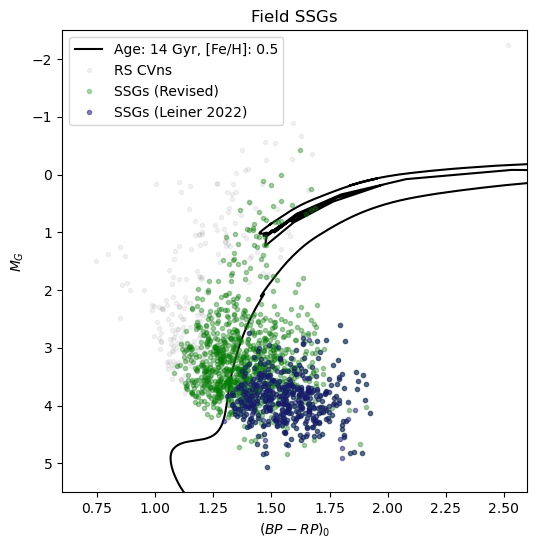

In [36]:
fig, ax = plt.subplots(1, figsize=(6,6))




ax.plot(BP_RP05, G_05, color = 'black', label='Age: 14 Gyr, [Fe/H]: 0.5')
ax.set_title(r'Field SSGs')
ax.plot(bp_rp[valid_feh], M_G[valid_feh],
        marker='.', linestyle='none', alpha=0.1,color = 'gray', label = 'RS CVns')#, color = 'darkmagenta')
ax.plot(bp_rp[ssgs], M_G[ssgs],
        marker='.', linestyle='none', alpha=0.3, color = 'green', label = 'SSGs (Revised)')

ax.plot(bp_rp[original_ssg], M_G[original_ssg],
        marker='.', linestyle='none', alpha=0.5, color = 'midnightblue', label = 'SSGs (Leiner 2022)')

ax.set_xlim(0.60, 2.60)
ax.set_ylim(-2.5,5.5)
ax.invert_yaxis()
ax.set_xlabel('$(BP-RP)_0$')
ax.set_ylabel('$M_G$')
ax.legend()


ssgs = (((fe_h2b & ssg_00) == True) | ((fe_h1b & ssg_05) == True )|
        ((fe_h3b & ssg_low025) == True ))

def frac(a,b):
    d = a/b * 100
    return round(d)


print('----------------------------- Full Sample ----------------------------------------------')
print('Original:', len(bp_rp[original_ssg]), 'or', str(frac(len(bp_rp[original_ssg]), len(bp_rp))) + '%')
print('Current:', len(bp_rp[ssgs]), 'or', str(frac(len(bp_rp[ssgs]), len(bp_rp))) + '%')
print('Total Size:', len(bp_rp))
print('----------------------------- With Valid [Fe/H] data ------------------------------------')
print('Original:', len(bp_rp[original_ssg]), 'or', str(frac(len(bp_rp[original_ssg]), len(bp_rp[valid_feh]))) + '%')
print('Current:', len(bp_rp[ssgs]), 'or', str(frac(len(bp_rp[ssgs]), len(bp_rp[valid_feh]))) + '%')
print('Total Size:', len(bp_rp[valid_feh]))

#fig_path_comp = path +  r'CMDs\ssg_comparison.png'
#fig.savefig(fig_path_comp, dpi = 300)

Text(0, 0.5, '$M_G$')

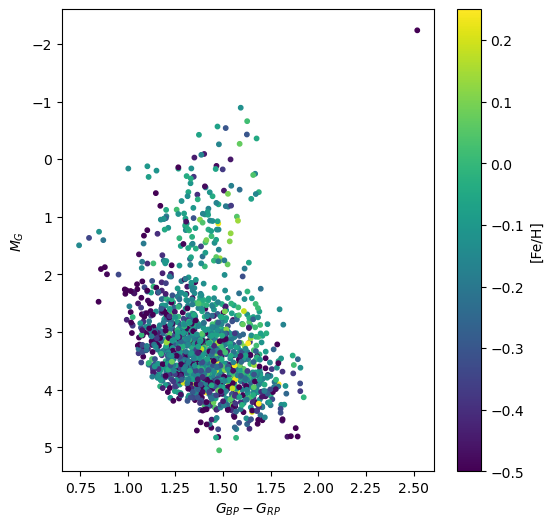

In [37]:
#Compare isocrone for all

#highlight HU Vir, FN Com
HUVir = gaia_data['SOURCE_ID'] == 3582095053777917952 #HU Vir
#FNCom = gaia_data['SOURCE_ID'] == 3947234928261838720 #FN Com

#Defining metallicty samples
fe_h1b = (metallicity > 0.0)
fe_h2b = (metallicity <= 0.0) & (metallicity > -0.25)
fe_h3b = (metallicity <= -0.25) 
#plotting colors for each sample

#plot a CMD with low and high mass samples highlighted
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

cs = ax.scatter(bp_rp, M_G, c=metallicity, s=10, vmin=-0.50, vmax=0.25)
cb = fig.colorbar(cs)

cb.set_label('[Fe/H]')
#ax.plot(bp_rp[fe_h2b], M_G[fe_h2b], marker='.', linestyle='none', 
#Highlight the targest stars
#ax.plot(bp_rp[HUVir], M_G[HUVir], marker='*', linestyle='none', alpha=1, color = 'blue')
#ax.text(bp_rp[HUVir], M_G[HUVir], 'HU Vir')
'''
ax.plot(bp_rp[FNCom], M_G[FNCom], marker='*', linestyle='none', 
        alpha=1, color = 'blue')
ax.text(bp_rp[FNCom], M_G[FNCom], 'FN Com')
'''


#ax.set_xlim(0, 3)
#ax.set_ylim(11, 1)
ax.invert_yaxis()
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')
#ax.legend()
#Paper here finds gaia metallicty is accurate for the most part

# SSG Analysis

In [39]:
ssg_file = r'C:\Users\astro\SSG_Spectra\Metallicities\SSG_Data2.csv'

df = pandas.read_csv(ssg_file, delimiter = ',')
print(df)

print(df.columns.tolist())

                       Star              Gaia ID      H-alpha Line  \
0                    29 Dra  1655646778064790528        Absorption   
1   2MASS J08171221+0736164  3097200805201566720        Absorption   
2   2MASS J08504952+1217158   605014833054650880          Emission   
3   2MASS J17270871+2700144  4571134418985782912        Absorption   
4                    54 Cam  1081565094046074624  Variable H-alpha   
..                      ...                  ...               ...   
70                 V498 And   387742126997049728  Variable H-alpha   
71                 V503 Hya   582882278166763648  Variable H-alpha   
72                 V832 Her  4573752837207321344        Absorption   
73                  V834Her  4597154602175212672        Absorption   
74                  V846Her  1302252161666670464        Absorption   

   Classification  RV Amplitude  Number of Observations  
0             cut         1.330                       4  
1              RS        13.865            

In [40]:
ssg_ids = np.array(df['Gaia ID'], dtype=np.int64)
raw_ssg_profile = np.array(df['H-alpha Line'], dtype=str)
raw_ssg_name = np.array(df['Star'], dtype = str)
raw_ssg_class = np.array(df['Classification'], dtype=str)

In [41]:
#av = np.array([av_tot[gaia_ids2.index(item)] for item in gaia_ids2 if item in gaia_data['SOURCE_ID']], 
              #dtype = float)

ssg_follow = [any(k == ssg_ids) for k in gaia_data['SOURCE_ID']]
ssg_sample = gaia_data[ssg_follow]
ssg_list = list(ssg_ids) #name of SSGs in RV sample

ssg_profile = np.array([raw_ssg_profile[ssg_list.index(item)] if item 
        in ssg_sample['SOURCE_ID'] else None for item in gaia_data['SOURCE_ID']], dtype = str)
ssg_name = np.array([raw_ssg_name[ssg_list.index(item)] if item 
        in ssg_sample['SOURCE_ID'] else None for item in gaia_data['SOURCE_ID']])
ssg_class = np.array([raw_ssg_class[ssg_list.index(item)] if item 
        in ssg_sample['SOURCE_ID'] else None for item in gaia_data['SOURCE_ID']])
'''

ssg_profile = np.array([raw_ssg_profile[ssg_list.index(item)] for item in ssg_sample['SOURCE_ID']], 
              dtype = str)
ssg_name = np.array([raw_ssg_name[ssg_list.index(item)] for item in ssg_sample['SOURCE_ID']], 
              dtype = str)
ssg_class = np.array([raw_ssg_class[ssg_list.index(item)] for item in ssg_sample['SOURCE_ID']], 
              dtype = str)
'''

"\n\nssg_profile = np.array([raw_ssg_profile[ssg_list.index(item)] for item in ssg_sample['SOURCE_ID']], \n              dtype = str)\nssg_name = np.array([raw_ssg_name[ssg_list.index(item)] for item in ssg_sample['SOURCE_ID']], \n              dtype = str)\nssg_class = np.array([raw_ssg_class[ssg_list.index(item)] for item in ssg_sample['SOURCE_ID']], \n              dtype = str)\n"

In [43]:
HUVir = gaia_data['SOURCE_ID'] == 3582095053777917952 #HU Vir
FNCom = gaia_data['SOURCE_ID'] == 3947234928261838720 
CGTri = gaia_data['SOURCE_ID'] == 326753999413912192
#Defining metallicty samples
variable_ha = (ssg_profile == 'Variable H-alpha')
absorption = (ssg_profile == 'Absorption')
emission = (ssg_profile == 'Emission')
#colors
emis_color = 'green'
abs_color = 'darkmagenta'
var_color = 'darkcyan'

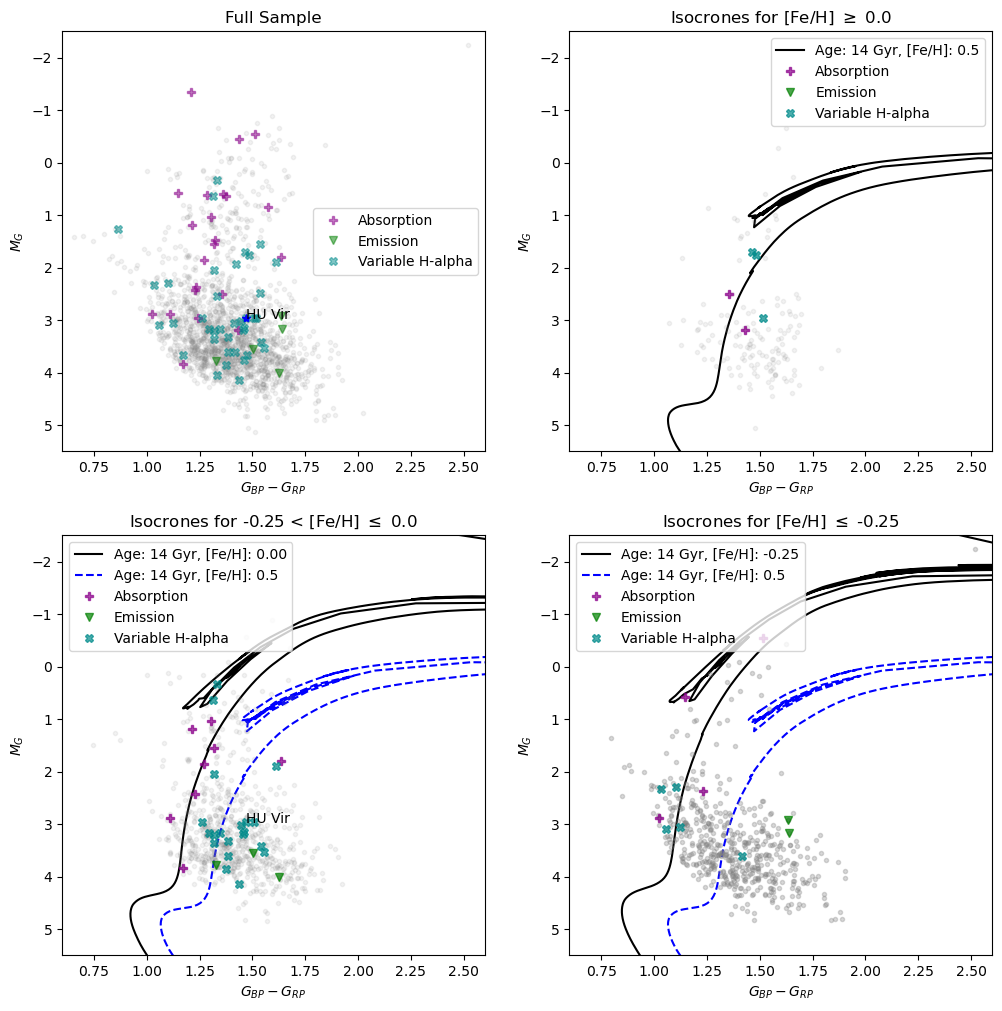

In [44]:

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
#full Sample
ax[0,0].set_title('Full Sample')
ax[0,0].plot(bp_rp, M_G, marker='.', linestyle='none', alpha=0.1, color = 'grey')

ax[0,0].plot(bp_rp[absorption], M_G[absorption], marker='P', linestyle='none', 
        alpha=0.5, color = abs_color, label = 'Absorption')
ax[0,0].plot(bp_rp[emission], M_G[emission], marker='v', linestyle='none', 
        alpha=0.5, color = emis_color, label = 'Emission')
ax[0,0].plot(bp_rp[variable_ha], M_G[variable_ha], marker='X', linestyle='none', 
        alpha=0.5, color = var_color, label = 'Variable H-alpha')

#Highlight the targest stars
ax[0,0].plot(bp_rp[HUVir], M_G[HUVir], marker='*', linestyle='none', 
        alpha=1, color = 'blue')
#ax[0,0].plot(bp_rp[FNCom], M_G[FNCom], marker='*', linestyle='none', alpha=1, color = 'blue')
#ax[0,0].text(bp_rp[FNCom], M_G[FNCom], 'FN Com')
ax[0,0].text(bp_rp[HUVir], M_G[HUVir], 'HU Vir')

ax[0,0].set_xlim(0.60, 2.60)
ax[0,0].set_ylim(-2.5,5.5)
ax[0,0].set_xlabel('$G_{BP}-G_{RP}$')
ax[0,0].set_ylabel('$M_G$')
ax[0,0].invert_yaxis()
ax[0,0].legend()

ax[0,1].set_title(r'Isocrones for [Fe/H] $\geq$ 0.0')
ax[0,1].plot(BP_RP05, G_05, color = 'black', label='Age: 14 Gyr, [Fe/H]: 0.5')
ax[0,1].plot(bp_rp[fe_h1b], M_G[fe_h1b],
        marker='.', linestyle='none', alpha=0.1, color = 'grey')
ax[0,1].plot(bp_rp[absorption & fe_h1b], M_G[absorption & fe_h1b], 
             marker='P', linestyle='none', alpha=0.7, color = abs_color, label = 'Absorption')
ax[0,1].plot(bp_rp[emission & fe_h1b], M_G[emission & fe_h1b], 
             marker='v', linestyle='none', alpha=0.7, color = emis_color, label = 'Emission')
ax[0,1].plot(bp_rp[variable_ha & fe_h1b], M_G[variable_ha & fe_h1b], 
             marker='X', linestyle='none', alpha=0.7, color = var_color, label = 'Variable H-alpha')

ax[0,1].set_xlim(0.60, 2.60)
ax[0,1].set_ylim(-2.5,5.5)
ax[0,1].invert_yaxis()
ax[0,1].set_xlabel('$G_{BP}-G_{RP}$')
ax[0,1].set_ylabel('$M_G$')
ax[0,1].legend()

#Subsample 2
ax[1,0].set_title(r'Isocrones for -0.25 < [Fe/H] $\leq$ 0.0')
#ax[1,0].plot(iso['logTeff'], iso['logL'], label=f'Age: 14 Gyr, [Fe/H]: 0.00')
ax[1,0].plot(BP_RP00, G_00, color = 'black', label='Age: 14 Gyr, [Fe/H]: 0.00')
ax[1,0].plot(BP_RP05, G_05, color = 'blue', linestyle = '--', label='Age: 14 Gyr, [Fe/H]: 0.5')
ax[1,0].plot(bp_rp[fe_h2b], M_G[fe_h2b], 
             marker='.', linestyle='none', alpha=0.1, color = 'grey')
ax[1,0].plot(bp_rp[absorption & fe_h2b], M_G[absorption & fe_h2b], 
             marker='P', linestyle='none', alpha=0.7, color = abs_color, label = 'Absorption')
ax[1,0].plot(bp_rp[emission & fe_h2b], M_G[emission & fe_h2b], 
             marker='v', linestyle='none', alpha=0.7, color = emis_color, label = 'Emission')
ax[1,0].plot(bp_rp[variable_ha & fe_h2b], M_G[variable_ha & fe_h2b], 
             marker='X', linestyle='none', alpha=0.7, color = var_color, label = 'Variable H-alpha')
ax[1,0].plot(bp_rp[HUVir], M_G[HUVir], marker='*', linestyle='none', 
        alpha=1, color = 'blue')
ax[1,0].text(bp_rp[HUVir], M_G[HUVir], 'HU Vir')

ax[1,0].set_xlim(0.60, 2.60)
ax[1,0].set_ylim(-2.5,5.5)
ax[1,0].invert_yaxis()
ax[1,0].set_xlabel('$G_{BP}-G_{RP}$')
ax[1,0].set_ylabel('$M_G$')
ax[1,0].legend()

#Subsample 3
ax[1,1].set_title(r'Isocrones for [Fe/H] $\leq$ -0.25')
ax[1,1].plot(BP_RP_low025, G_low025, color = 'black', label='Age: 14 Gyr, [Fe/H]: -0.25')
ax[1,1].plot(BP_RP05, G_05, color = 'blue', linestyle = '--', label='Age: 14 Gyr, [Fe/H]: 0.5')
#ax[1,1].plot(iso['logTeff'], iso['logL'], label=f'Age: 14 Gyr, [Fe/H]: -0.25')
ax[1,1].plot(bp_rp[fe_h3b], M_G[fe_h3b],
             marker='.', linestyle='none', alpha=0.3, color = 'grey')
ax[1,1].plot(bp_rp[absorption & fe_h3b], M_G[absorption & fe_h3b], 
             marker='P', linestyle='none', alpha=0.7, color = abs_color, label = 'Absorption')
ax[1,1].plot(bp_rp[emission & fe_h3b], M_G[emission & fe_h3b], 
             marker='v', linestyle='none', alpha=0.7, color = emis_color, label = 'Emission')
ax[1,1].plot(bp_rp[variable_ha & fe_h3b], M_G[variable_ha & fe_h3b], 
             marker='X', linestyle='none', alpha=0.7, color = var_color, label = 'Variable H-alpha')

ax[1,1].set_xlim(0.60, 2.60)
ax[1,1].set_ylim(-2.5,5.5)
ax[1,1].invert_yaxis()
ax[1,1].set_xlabel('$G_{BP}-G_{RP}$')
ax[1,1].set_ylabel('$M_G$')
ax[1,1].legend()

# SSG Periods

In [45]:
#finds periods
periods_tot = np.genfromtxt(file, usecols= 12, dtype = float)


#names = np.genfromtxt(file, usecols= 1, dtype = str) + np.genfromtxt(file, usecols= 2, dtype = str)
periods = np.array([periods_tot[gaia_ids2.index(item)] for item in gaia_data['SOURCE_ID']], 
              dtype = float)

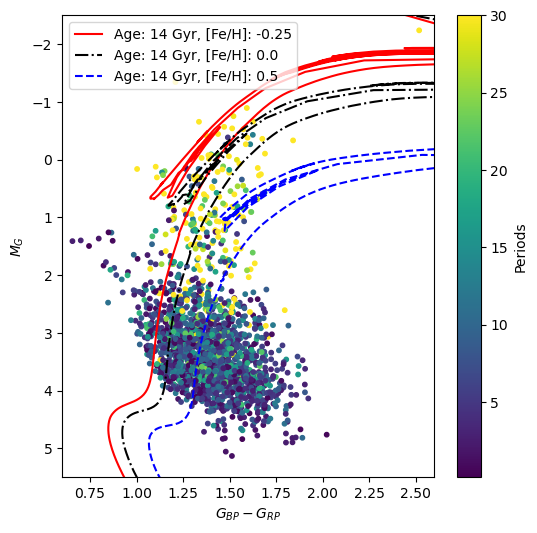

In [48]:
#highlight HU Vir, FN Com


#plotting colors for each sample

#plot a CMD with low and high mass samples highlighted
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

cs = ax.scatter(bp_rp, M_G, c=periods, s=10, vmax=30)
ax.plot(BP_RP_low025, G_low025, color = 'red', label='Age: 14 Gyr, [Fe/H]: -0.25')
ax.plot(BP_RP00, G_00, color = 'black', linestyle = '-.', label='Age: 14 Gyr, [Fe/H]: 0.0')
ax.plot(BP_RP05, G_05, color = 'blue', linestyle = '--', label='Age: 14 Gyr, [Fe/H]: 0.5')
cb = fig.colorbar(cs)

cb.set_label('Periods')

ax.set_xlim(0.60, 2.60)
ax.set_ylim(-2.5,5.5)
ax.invert_yaxis()
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

ax.legend()
#Paper here finds gaia metallicty is accurate for the most part

Text(0, 0.5, '$M_G$')

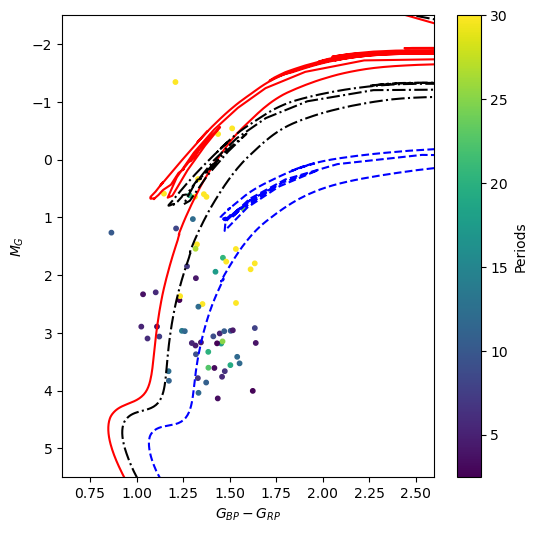

In [49]:
#highlight HU Vir, FN Com


#plotting colors for each sample

#plot a CMD with low and high mass samples highlighted
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

cs = ax.scatter(bp_rp[ssg_follow], M_G[ssg_follow], 
                c=periods[ssg_follow], s=10, vmax=30)
ax.plot(BP_RP_low025, G_low025, color = 'red', label='Age: 14 Gyr, [Fe/H]: -0.25')
ax.plot(BP_RP00, G_00, color = 'black', linestyle = '-.', label='Age: 14 Gyr, [Fe/H]: 0.0')
ax.plot(BP_RP05, G_05, color = 'blue', linestyle = '--', label='Age: 14 Gyr, [Fe/H]: 0.5')
cb = fig.colorbar(cs)

cb.set_label('Periods')


ax.set_xlim(0.60, 2.60)
ax.set_ylim(-2.5,5.5)
ax.invert_yaxis()
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')
#ax.legend()
#Paper here finds gaia metallicty is accurate for the most part

Text(0, 0.5, 'Number of Stars')

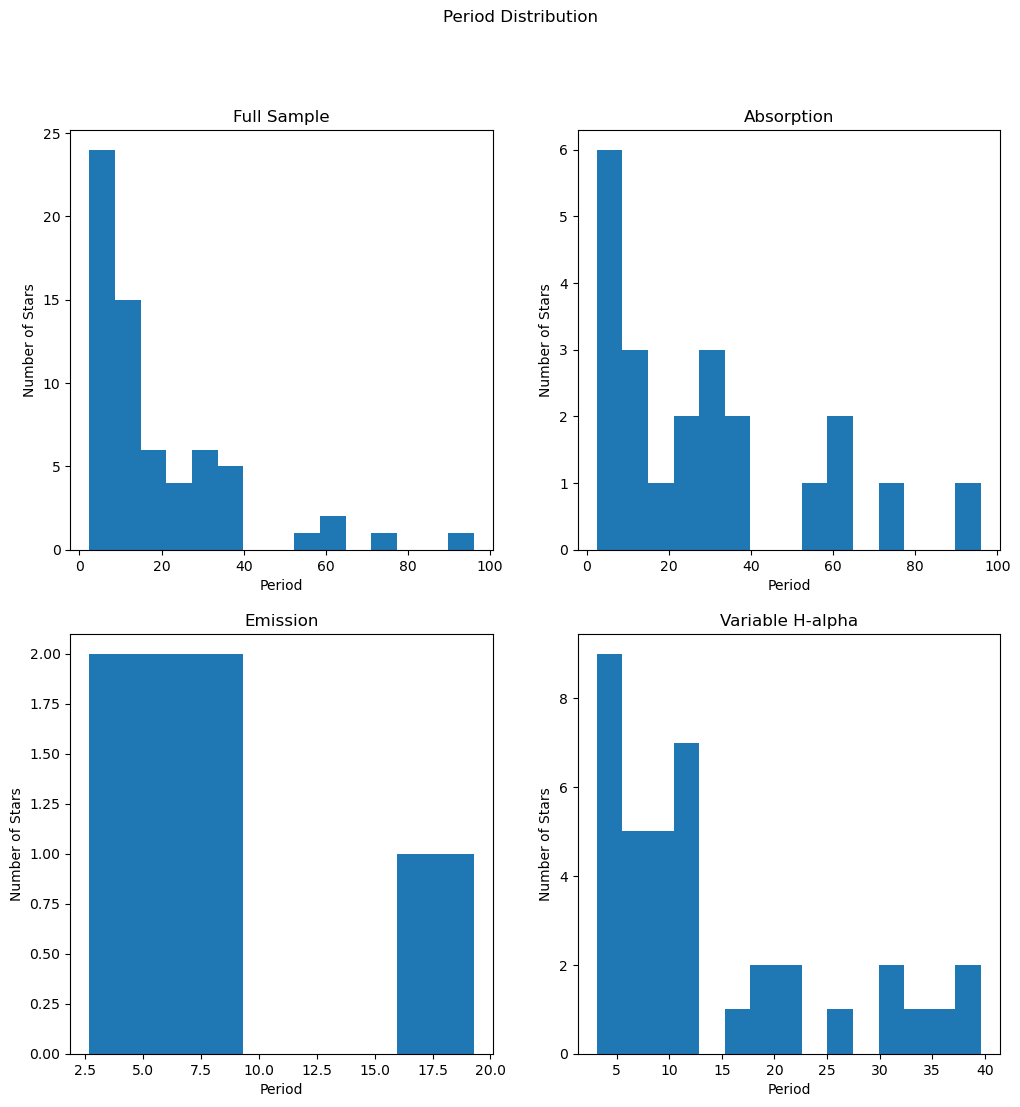

In [50]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fill in the missing code to create a histogram of Z, the height above/below the midplane.
#matplotlib.pyplot.hist documentation is here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
fig.suptitle('Period Distribution')
ax[0,0].hist(periods[ssg_follow], 15)
ax[0,0].set_title('Full Sample')
#ax[0,0].set_xlim(right=40)
ax[0,0].set_xlabel("Period")
ax[0,0].set_ylabel("Number of Stars")

#Absorption
ax[0,1].hist(periods[absorption], 15)
ax[0,1].set_title('Absorption')
ax[0,1].set_xlabel("Period")
ax[0,1].set_ylabel("Number of Stars")

#Emission
ax[1,0].hist(periods[emission], 5)
ax[1,0].set_title('Emission')
ax[1,0].set_xlabel("Period")
ax[1,0].set_ylabel("Number of Stars")

#Variable
ax[1,1].hist(periods[variable_ha], 15)
ax[1,1].set_title('Variable H-alpha')
ax[1,1].set_xlabel("Period")
ax[1,1].set_ylabel("Number of Stars")

Text(0, 0.5, 'Number of Stars')

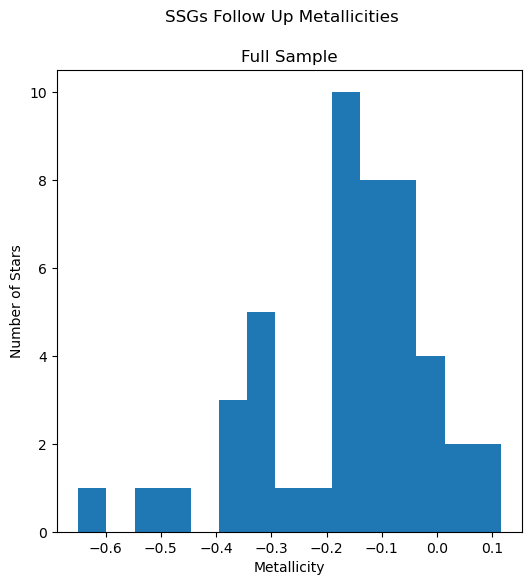

In [51]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
#fill in the missing code to create a histogram of Z, the height above/below the midplane.
#matplotlib.pyplot.hist documentation is here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
fig.suptitle('SSGs Follow Up Metallicities')
ax.hist(metallicity[ssg_follow], 15)
ax.set_title('Full Sample')
ax.set_xlabel("Metallicity")
ax.set_ylabel("Number of Stars")

Text(0, 0.5, 'Number of Stars')

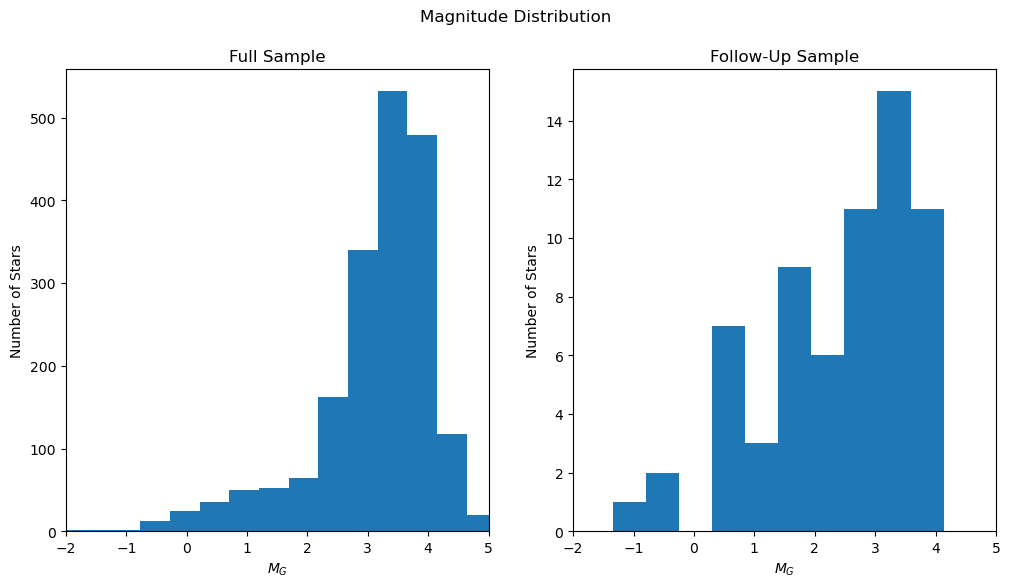

In [52]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
#fill in the missing code to create a histogram of Z, the height above/below the midplane.
#matplotlib.pyplot.hist documentation is here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

fig.suptitle('Magnitude Distribution')
ax[0].hist(M_G, 15)
ax[0].set_title('Full Sample')
ax[0].set_xlim(-2,5)
ax[0].set_xlabel("$M_G$")
ax[0].set_ylabel("Number of Stars")

ax[1].hist(M_G[ssg_follow], 10)
#ax[1].hist(M_G[ssg_follow][absorption], 15, color='darkmagenta')
#ax[1].hist(M_G[ssg_follow][emission], 15, color = 'green')
#ax[1].hist(M_G[ssg_follow][variable_ha], 15, color = 'darkcyan')
ax[1].set_xlim(-2,5)
ax[1].set_title('Follow-Up Sample')
ax[1].set_xlabel("$M_G$")
ax[1].set_ylabel("Number of Stars")

Text(0, 0.5, 'Number of Stars')

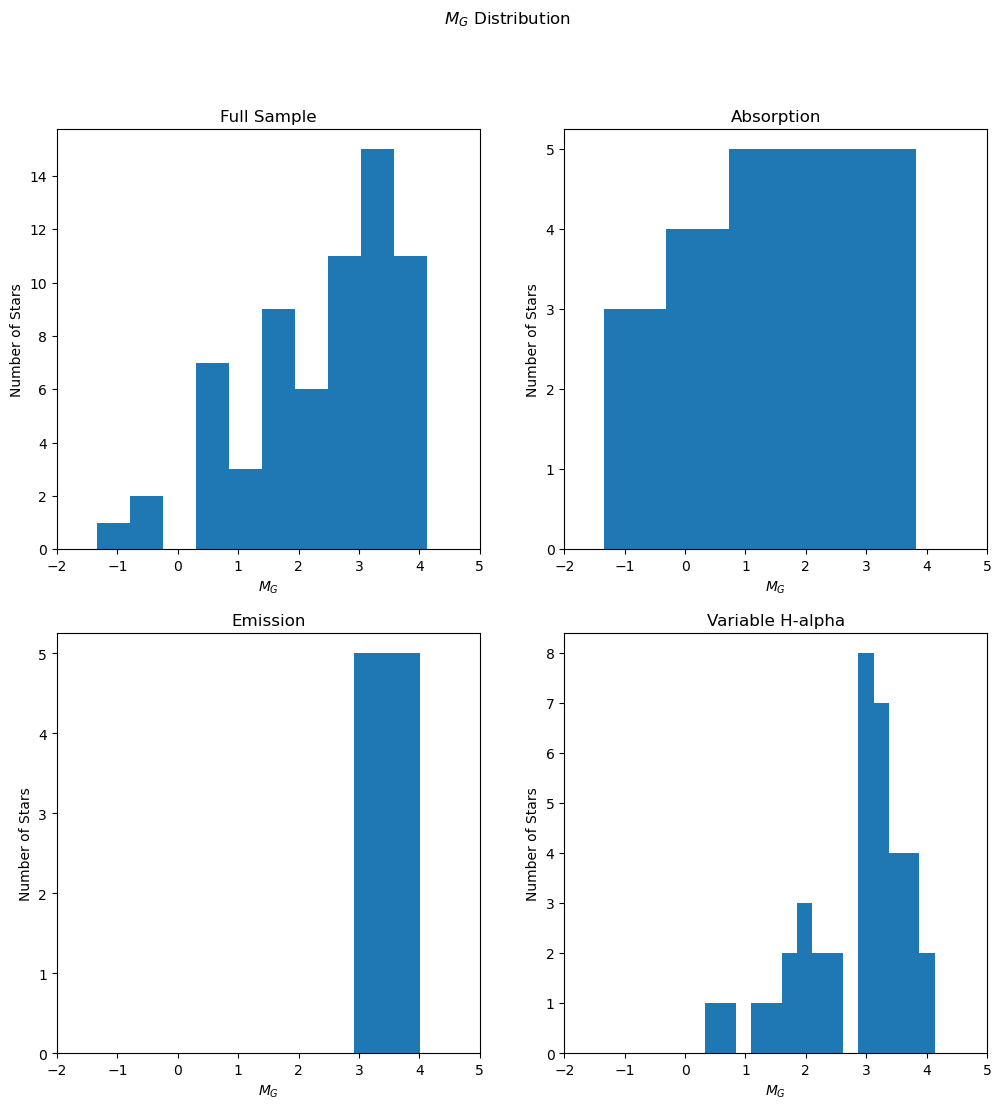

In [53]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fill in the missing code to create a histogram of Z, the height above/below the midplane.
#matplotlib.pyplot.hist documentation is here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
fig.suptitle('$M_G$ Distribution')
ax[0,0].hist(M_G[ssg_follow], 10)
ax[0,0].set_title('Full Sample')
ax[0,0].set_xlim(-2,5)
ax[0,0].set_xlabel("$M_G$")
ax[0,0].set_ylabel("Number of Stars")

#Absorption
ax[0,1].hist(M_G[absorption], 5)
ax[0,1].set_xlim(-2,5)
ax[0,1].set_title('Absorption')
ax[0,1].set_xlabel("$M_G$")
ax[0,1].set_ylabel("Number of Stars")

#Emission
ax[1,0].hist(M_G[emission], 1)
ax[1,0].set_xlim(-2,5)
ax[1,0].set_title('Emission')
ax[1,0].set_xlabel("$M_G$")
ax[1,0].set_ylabel("Number of Stars")

#Variable
ax[1,1].hist(M_G[variable_ha], 15)
ax[1,1].set_xlim(-2,5)
ax[1,1].set_title('Variable H-alpha')
ax[1,1].set_xlabel("$M_G$")
ax[1,1].set_ylabel("Number of Stars")

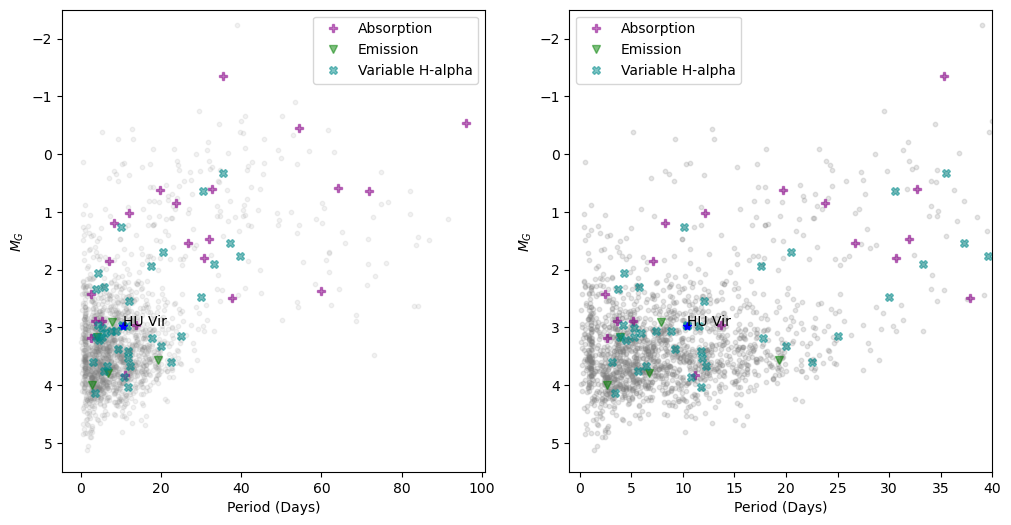

In [54]:
#highlight HU Vir, FN Com


#plotting colors for each sample

#plot a CMD with low and high mass samples highlighted
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(periods, M_G, s=10, color = 'grey', alpha = 0.1)#, vmax=30)

ax[0].plot(periods[absorption], M_G[absorption], marker='P', linestyle='none', 
        alpha=0.5, color = abs_color, label = 'Absorption')
ax[0].plot(periods[emission], M_G[emission], marker='v', linestyle='none', 
        alpha=0.5, color = emis_color, label = 'Emission')
ax[0].plot(periods[variable_ha], M_G[variable_ha], marker='X', linestyle='none', 
        alpha=0.5, color = var_color, label = 'Variable H-alpha')
ax[0].set_ylim(-2.5,5.5)


ax[0].plot(periods[HUVir], M_G[HUVir], marker='*', linestyle='none', color='b', alpha = 1.0)
ax[0].text(periods[HUVir], M_G[HUVir], 'HU Vir')
ax[0].invert_yaxis()
ax[0].set_xlabel('Period (Days)')
ax[0].set_ylabel('$M_G$')
ax[0].legend()


ax[1].scatter(periods, M_G, s=10, color = 'grey', alpha = 0.1)#, vmax=30)
ax[1].scatter(periods, M_G, s=10, color = 'grey', alpha = 0.1)#, vmax=30)

ax[1].plot(periods[absorption], M_G[absorption], marker='P', linestyle='none', 
        alpha=0.5, color = abs_color, label = 'Absorption')
ax[1].plot(periods[emission], M_G[emission], marker='v', linestyle='none', 
        alpha=0.5, color = emis_color, label = 'Emission')
ax[1].plot(periods[variable_ha], M_G[variable_ha], marker='X', linestyle='none', 
        alpha=0.5, color = var_color, label = 'Variable H-alpha')
ax[1].plot(periods[HUVir], M_G[HUVir], marker='*', linestyle='none', color='b', alpha = 1.0)
ax[1].text(periods[HUVir], M_G[HUVir], 'HU Vir')

ax[1].set_ylim(-2.5,5.5)
ax[1].set_xlim(-1, 40)
ax[1].invert_yaxis()
ax[1].set_xlabel('Period (Days)')
ax[1].set_ylabel('$M_G$')
ax[1].legend()
#ax.legend()
#Paper here finds gaia metallicty is accurate for the most part

In [55]:
#period bins
period1 = (periods > 40)
period2 = ((periods <= 40) & (periods > 20 )) 
period3 = (periods <= 20)

Text(0, 0.5, 'Number of Stars')

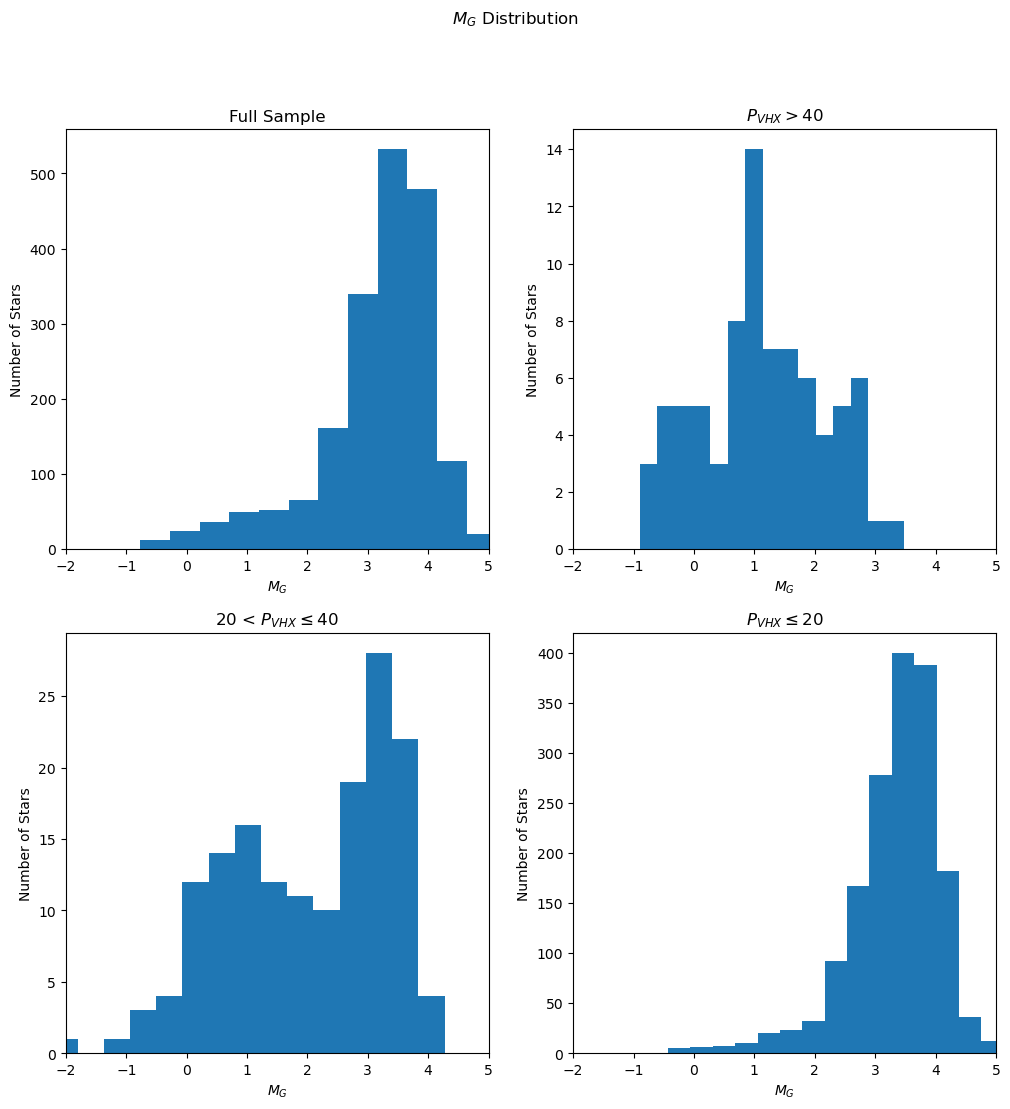

In [56]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fill in the missing code to create a histogram of Z, the height above/below the midplane.
#matplotlib.pyplot.hist documentation is here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
fig.suptitle('$M_G$ Distribution')
ax[0,0].hist(M_G, 15)
ax[0,0].set_title('Full Sample')
ax[0,0].set_xlim(-2,5)
ax[0,0].set_xlabel("$M_G$")
ax[0,0].set_ylabel("Number of Stars")

#Absorption
ax[0,1].hist(M_G[period1], 15)
ax[0,1].set_xlim(-2,5)
ax[0,1].set_title('$P_{VHX} > 40$')
ax[0,1].set_xlabel("$M_G$")
ax[0,1].set_ylabel("Number of Stars")

#Emission
ax[1,0].hist(M_G[period2], 15)
ax[1,0].set_xlim(-2,5)
ax[1,0].set_title('20 < $P_{VHX} \leq 40$')
ax[1,0].set_xlabel("$M_G$")
ax[1,0].set_ylabel("Number of Stars")

#Variable
ax[1,1].hist(M_G[period3], 15)
ax[1,1].set_xlim(-2,5)
ax[1,1].set_title('$P_{VHX} \leq 20$')
ax[1,1].set_xlabel("$M_G$")
ax[1,1].set_ylabel("Number of Stars")

Text(0, 0.5, 'Number of Stars')

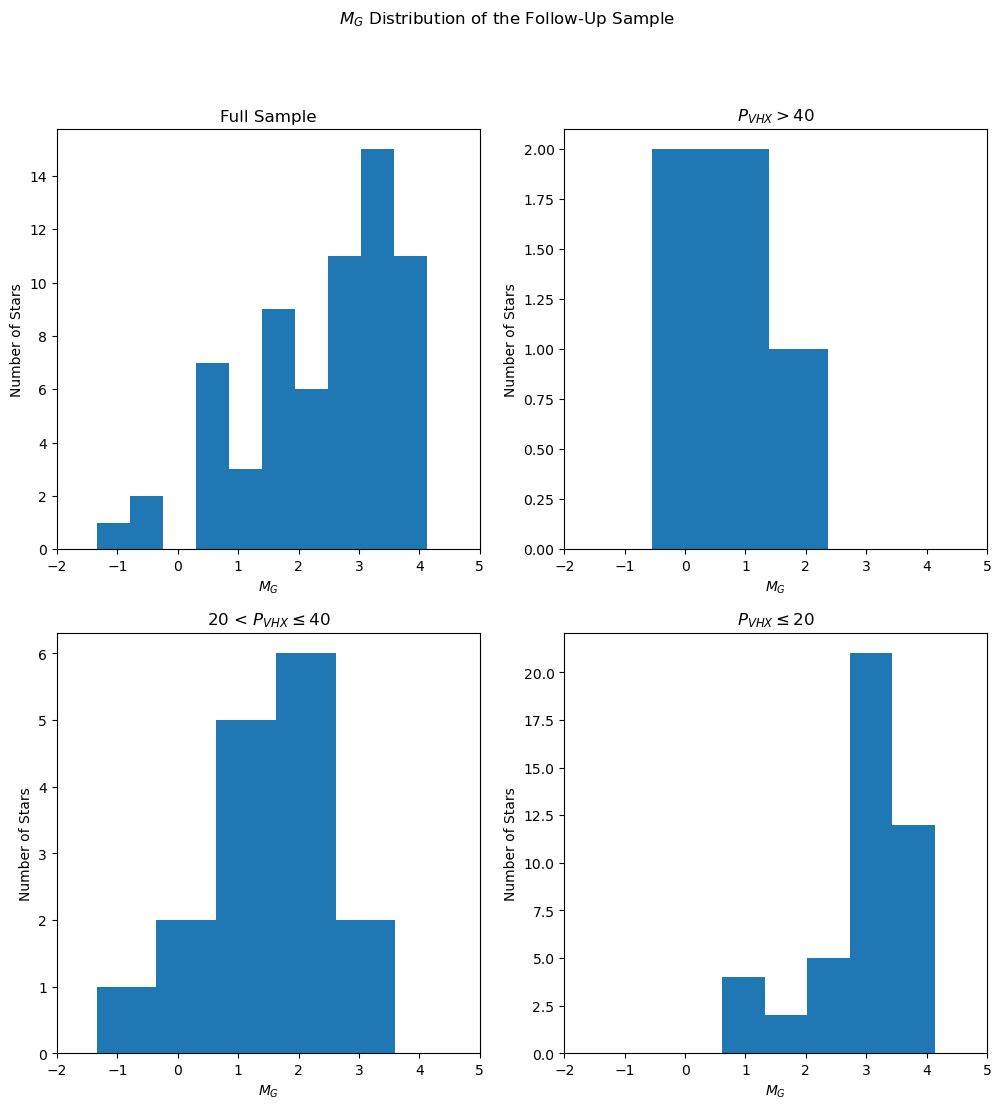

In [57]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fill in the missing code to create a histogram of Z, the height above/below the midplane.
#matplotlib.pyplot.hist documentation is here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
fig.suptitle('$M_G$ Distribution of the Follow-Up Sample')
ax[0,0].hist(M_G[ssg_follow], 10)
ax[0,0].set_title('Full Sample')
ax[0,0].set_xlim(-2,5)
ax[0,0].set_xlabel("$M_G$")
ax[0,0].set_ylabel("Number of Stars")

#Absorption
ax[0,1].hist(M_G[period1 & ssg_follow], 3)
ax[0,1].set_xlim(-2,5)
ax[0,1].set_title('$P_{VHX} > 40$')
ax[0,1].set_xlabel("$M_G$")
ax[0,1].set_ylabel("Number of Stars")

#Emission
ax[1,0].hist(M_G[period2 & ssg_follow], 5)
ax[1,0].set_xlim(-2,5)
ax[1,0].set_title('20 < $P_{VHX} \leq 40$')
ax[1,0].set_xlabel("$M_G$")
ax[1,0].set_ylabel("Number of Stars")

#Variable
ax[1,1].hist(M_G[period3 & ssg_follow], 5)
ax[1,1].set_xlim(-2,5)
ax[1,1].set_title('$P_{VHX} \leq 20$')
ax[1,1].set_xlabel("$M_G$")
ax[1,1].set_ylabel("Number of Stars")

# Create Files Here

In [ ]:
raw_star_name1 = np.genfromtxt(file, usecols=1, dtype = str)
raw_star_name2 = np.genfromtxt(file, usecols=2, dtype = str)
star_name1 = np.array([raw_star_name1[gaia_ids2.index(item)] for item in gaia_data['SOURCE_ID']], dtype = str)
star_name2 = np.array([raw_star_name2[gaia_ids2.index(item)] for item in gaia_data['SOURCE_ID']], dtype = str)
star_name = np.array([star_name1[k] + ' ' + star_name2[k] for k in range(len(star_name1))])

class_list = []
for i in range(len(ssgs)):
    if (ssgs[i] == True):
        class_list.append('SSG')
    elif (valid_feh[i] == True):
        class_list.append('RS')
    else:
        class_list.append('cut')
class_list = np.array(class_list)



fe_h_list = []
for i in range(len(metallicity)):
    if valid_feh[i] == False:
        fe_h_list.append(int(-999))
    else:
        fe_h_list.append(metallicity[i])
fe_h_list = np.array(fe_h_list)

In [ ]:
final_dict = {'ID': np.array(gaia_data['SOURCE_ID']), 'Name': star_name, 'ra': np.round(gaia_data['ra'],5), 
            'dec': np.round(gaia_data['dec'],5), 'dist': np.array(dist, dtype = int),'g_mag': np.round(m_G, 2), 
              'BP-RP': np.round(gaia_data['bp_rp'],2), 'fe_h': np.round(fe_h_list,5), 
              'AV': av, 'leiner_class': leiner2022_class, 'class': class_list}

final_df = pandas.DataFrame(final_dict)

print(final_df)
final_df.to_csv(path + 'CMDs\\updated_SSGsv1a.csv', index=False)

In [ ]:
print(any((class_list == 'cut') & (leiner2022_class == 'SSG')))